In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [8]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

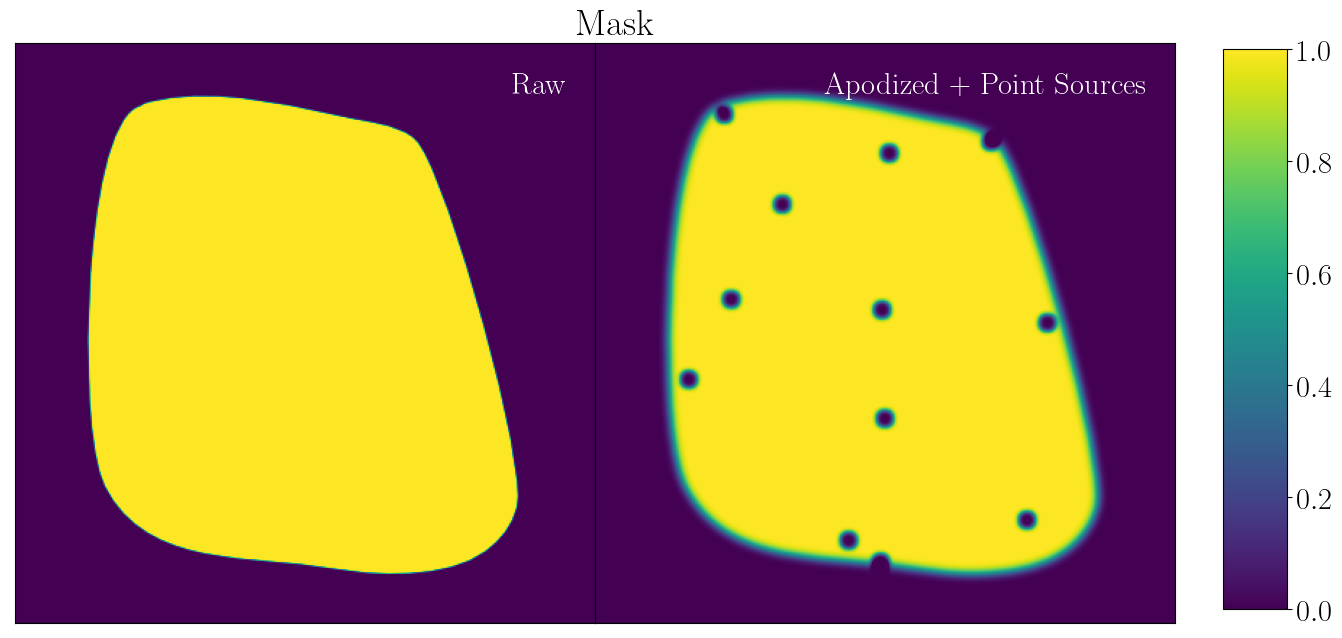

In [93]:
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig.subplots_adjust(wspace=0, hspace=0)

im0 = axs[0].imshow(mask)
im1 = axs[1].imshow(apodized_mask)


for ax,s in zip(axs, ['Raw', 'Apodized + Point Sources']):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(.95, .95,
        s=s,
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='top',
            c='white',
       fontsize=22)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax)
fig.suptitle('Mask', y=.9)

plt.savefig('figures/mask%dx%d.pdf'%(nX,nY), bbox_inches='tight')

Generate GRF unlensed CMB map (debeamed)
Generate GRF kappa map
Lens the CMB map
Generate FG map
Add white detector noise (debeamed)
Masking the map


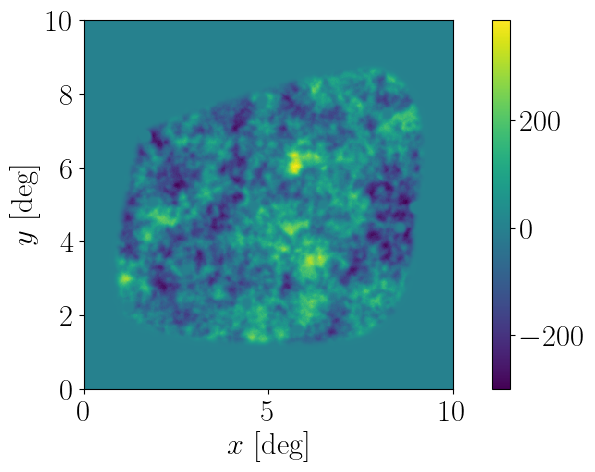

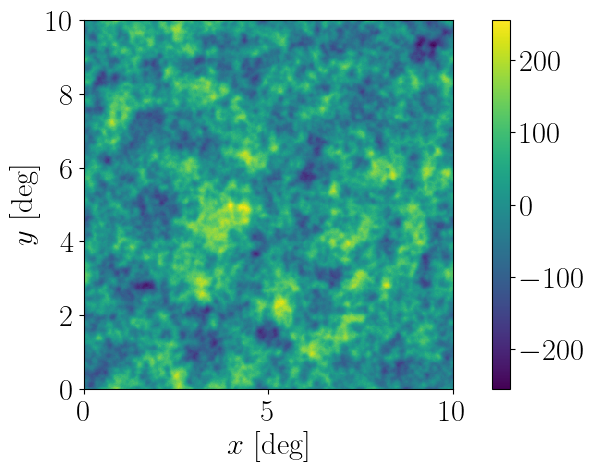

In [17]:

print("Generate GRF unlensed CMB map (debeamed)")

#generate GRF with the same power spectrum as the unlensed CMB
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)

print("Generate GRF kappa map")

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

print("Lens the CMB map")

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)

print("Generate FG map")

fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

print("Add white detector noise (debeamed)")

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)

print("Masking the map")

totalMaskedCmb = apodized_mask*totalCmb
totalMaskedCmbFourier = baseMap.fourier(totalMaskedCmb)

baseMap.plot(totalMaskedCmb)

totalMaskedCmbFourierRandomized = baseMap.randomizePhases(totalMaskedCmbFourier)
totalMaskedCmbRandomized = baseMap.inverseFourier(totalMaskedCmbFourierRandomized)

baseMap.plot(totalMaskedCmbRandomized)

In [18]:
import pickle
mean_field = pickle.load(open('mask_simple%dx%d_point_sources_bigger.pkl'%(nX,nY), 'rb'))

In [67]:
fsky = np.sum(apodized_mask)/(nX*nY)
c1 = fsky
c2 = fsky**2

In [62]:
kappa = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax,
                                        dataFourier=totalMaskedCmbFourier)
kappa -= mean_field

kappa_R = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax,
                                        dataFourier=totalMaskedCmbFourierRandomized)

/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [68]:
Cls = {}

key='kk'
Cls[key] = [0,0,0]
Cls[key][0], Cls[key][1], Cls[key][2] = baseMap.powerSpectrum(dataFourier=kappa)
Cls[key][1]/=c1
Cls[key][2]/=c1

key='kkR'
Cls[key] = [0,0,0]
Cls[key][0], Cls[key][1], Cls[key][2] = baseMap.powerSpectrum(dataFourier=kappa_R)
Cls[key][1]/=c2
Cls[key][2]/=c2

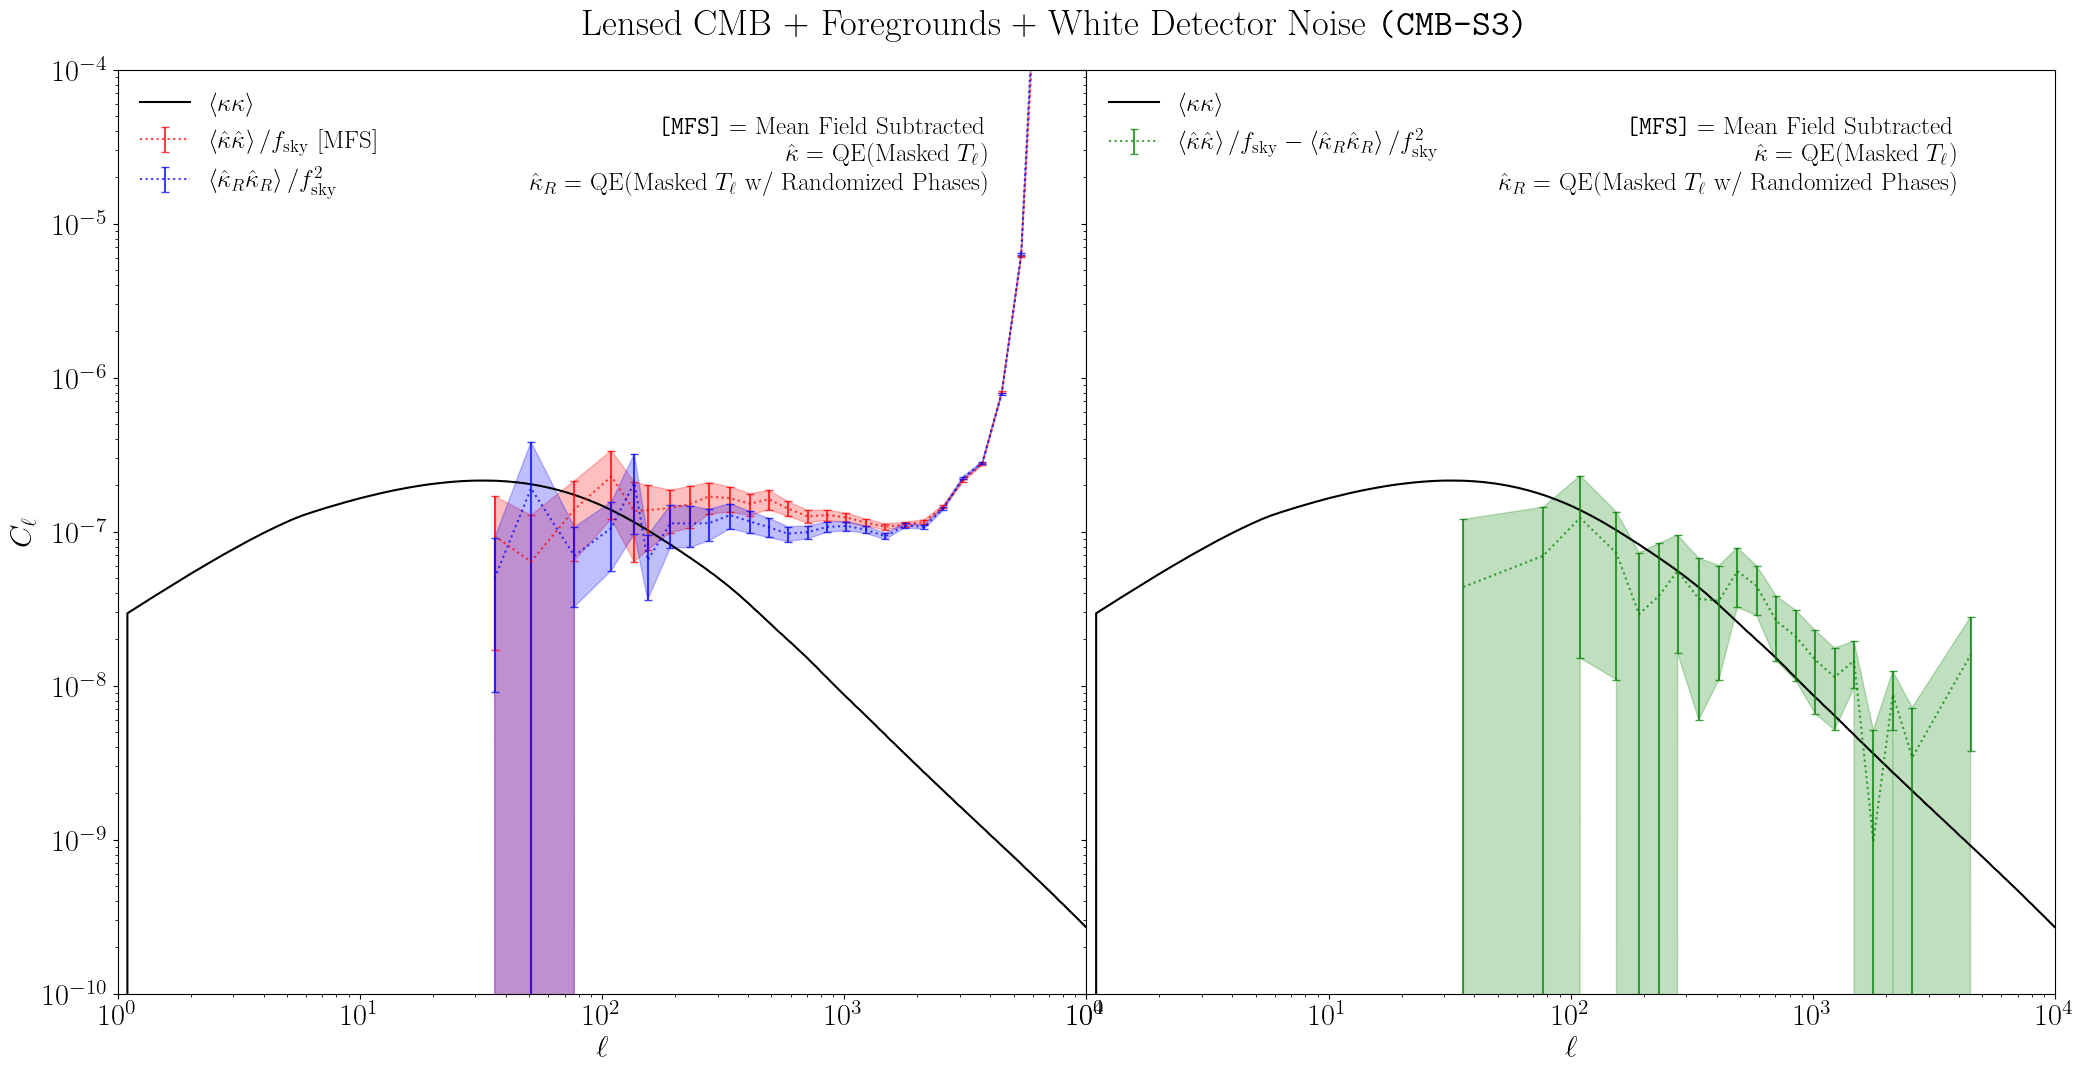

In [90]:
fig, axs = plt.subplots(ncols=2, figsize=(25,12))
fig.subplots_adjust(wspace=0, hspace=0)


ell = baseMap.l.flatten()
factor = 1. # lCen**2

labels = {
    'kk': r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky}$ [MFS]',
    'kkR': r'$\left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2$ ',
}


theory=[p2d_cmblens.fPinterp]#, fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$', r'Projected noise $N$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, factor*ClExpected, sty, label=l)

col = dict(zip(Cls.keys(), ['red','blue']))
for key in Cls:
    ax = axs[0]
    lCen, Cl, sCl = Cls[key]

    Ipos = np.where(Cl>=1e-10)
    Ineg = np.where(Cl<0.)

    fctr = factor
        
        
    ax.errorbar(lCen[Ipos], factor*(Cl[Ipos]), yerr=fctr*sCl[Ipos], c=col[key], alpha=.75, 
                fmt=':', capsize=3, label=labels[key], capthick=1)
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip(factor*(Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip(factor*(Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    ax.set_ylabel(r'$C_\ell$')
    
    
lCen, Cl, sCl = np.copy(Cls['kk'])
Cl -= Cls['kkR'][1]
Ipos = np.where(Cl>=1e-10)

fctr = factor

axs[1].errorbar(lCen[Ipos], factor*(Cl[Ipos]), yerr=fctr*sCl[Ipos], c='g', alpha=.75, 
            fmt=':', capsize=3, 
            label=r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \left<\hat\kappa_R \hat\kappa_R\right>/f_{\rm sky}^2$', 
            capthick=1)
tmp_data = {
    'x': lCen[Ipos],
    'y1': [y - e for y, e in zip(factor*(Cl[Ipos]), sCl[Ipos])],
    'y2': [y + e for y, e in zip(factor*(Cl[Ipos]), sCl[Ipos])]}
axs[1].fill_between(**tmp_data, color='g', alpha=.25)

    
for ax in axs:    
    ax.set_xlim(1, 1e4)
    ax.set_ylim(1e-10, 1e-4)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    s = r'\texttt{[MFS]} = Mean Field Subtracted'
    s += '\n'
    s += r'$\hat\kappa$ = QE(Masked $T_{\mathbf \ell}$)'
    s += '\n'
    s += r'$\hat\kappa_R$ = QE(Masked $T_{\mathbf \ell}$ w/ Randomized Phases)'
    ax.text(.9, .95,
        s=s,
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=18)


    
    l=ax.legend(frameon=False, loc='upper left')
axs[1].set_yticklabels([])

fig.suptitle(r'Lensed CMB + Foregrounds + White Detector Noise \texttt{(CMB-S3)}', y=0.93)
plt.savefig('figures/randomized_phases.pdf', bbox_inches='tight')